# ML: Breast Cancer

## Part 0: Pre-requisites 

### Imports

In [1]:
!pip install keras.wrappers
!pip install tensorflow
!pip install scikeras
!pip install keras==2.15.0

ERROR: Could not find a version that satisfies the requirement keras.wrappers (from versions: none)
ERROR: No matching distribution found for keras.wrappers


   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.1 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.1 MB 1.1 MB/s eta 0:00:01
   -- ------------------------------------- 0.1/1.1 MB 1.1 MB/s eta 0:00:01
   -- ------------------------------------- 0.1/1.1 MB 1.1 MB/s eta 0:00:01
   ----- ---------------------------------- 0.1/1.1 MB 847.9 kB/s eta 0:00:02
   ------ --------------------------------- 0.2/1.1 MB 807.1 kB/s eta 0:00:02
   ------- -------------------------------- 0.2/1.1 MB 778.2 kB/s eta 0:00:02
   -------- ------------------------------- 0.2/1.1 MB 808.4 kB/s eta 0:00:02
   --------- ------------------------------ 0.3/1.1 MB 785.2 kB/s eta 0:00:02
   ----------- ---------------------------- 0.3/1.1 MB 791.9 kB/s eta 0:00:01
   ----------- ---------------------------- 0.3/1.1 MB 754.8 kB/s eta 0:00:02
   ------------- -------------------------- 0.4/1.1 MB 768.6 kB/s eta 0:00:01
   -------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.16.1 requires keras>=3.0.0, but you have keras 2.15.0 which is incompatible.



  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1


In [17]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV

### Function to plot the learning curve 

In [18]:
def plot_learning_curves(model, x_train, y_train, x_val, y_val):
    train_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curves")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

### Function to split the data 

In [19]:
def train_val_test_split(x, y):
    # Splitting into training (80%) and temporary set (20%)
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=3)
    # Splitting the temporary set into validation (50%) and test (50%)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=True, random_state=3)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [20]:
# Used locally 
path = "C:\\Users\\aidaf\\OneDrive\\Documents\\University\\Spring 2023-2024\\CMPS 396V Machine Learning\\Project\\ML_Breast_Cancer\\Models\\"

# Used to load and save models for later use

def saveModel(fileName, model):
  with open(path + fileName, 'wb') as f:
      pickle.dump(model, f)

def getModel(fileName):
  with open(path + fileName, 'rb') as f:
      loaded_model = pickle.load(f)

In [21]:
results = [] # Array used to store tuples of (model, accuracy_score)

## Part 1: Data 


### Load the data 

In [22]:
data = pd.read_csv("data.csv", encoding="utf-8")
data.head()

C:\Users\aidaf\AppData\Local\Temp\ipykernel_22952\3240169054.py:1: DtypeWarning: Columns (662,664,676,677,683,685,686,687) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data.csv", encoding="utf-8")


,cancer_type,patient_id,age_at_diagnosis,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,Breast Invasive Ductal Carcinoma,474,54.29,High,1,LumB,1,Positve,Positive,3.0,...,0,0,0,0,0,0,0,0,0,0
1,Breast Invasive Ductal Carcinoma,7029,43.45,Moderate,0,LumA,4,Positve,Positive,1.0,...,0,0,0,0,0,0,0,0,0,0
2,Breast Invasive Ductal Carcinoma,5215,74.11,High,0,LumB,3,Positve,Positive,3.0,...,0,0,0,0,0,0,0,0,0,0
3,Breast Invasive Ductal Carcinoma,5412,51.87,High,0,LumA,3,Positve,Positive,2.0,...,0,0,0,0,0,0,0,0,0,0
4,Breast Invasive Ductal Carcinoma,465,87.18,Moderate,0,LumB,1,Positve,Positive,3.0,...,0,0,0,0,0,0,0,0,0,0


### Clean the data

#### Remove missing and duplicate values from dataset

In [23]:
# Check and remove missing values from the dataset
data.isna().sum()
data.dropna(axis=0, inplace=True)
data.reset_index(inplace=True)

In [24]:
# Check and remove duplicate values from the dataset
data.duplicated().sum()
data.drop_duplicates(inplace=True)

#### Split the data into train, validation, and test sets 

Given the dataset size (around 1500) we can go with either approach (spliting the data manualy or applying cross-validation)

Split the dataset into train (80%), validation (10%) and test (10%) sets

In [25]:
y = data["cancer_type"]
x = data.drop(columns = "cancer_type")

x_encoded = pd.get_dummies(x)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(x_encoded, y_encoded)

## Part 2: Dimensionality Reduction - Deprecated for now (DON'T RUN THE CELLS IN THIS SECTION)

In [10]:
# Dimensionality Reduction 
# Normalize the data
# Select columns with float or integer data types
df = pd.DataFrame(data)

numeric_columns = df.select_dtypes(include=['float64', 'int64'])
data_normalized = (numeric_columns - np.mean(numeric_columns, axis=0)) / np.std(numeric_columns, axis=0)

# Perform PCA
n_components = 10  # Number of components to keep
pca = PCA(n_components=n_components)
data_reduced = pca.fit_transform(data_normalized)
data_reduced

NameError: name 'df' is not defined

In [11]:
# Assuming df is your DataFrame
# Example DataFrame
df = pd.DataFrame(data)

# Select only numeric columns for correlation calculation
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
corr_matrix = numeric_columns.corr().abs()

# Set the threshold for correlation
threshold = 0.7  # You can adjust this threshold as needed

# Find features with high correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Drop highly correlated features
df_reduced = df.drop(to_drop, axis=1)

# Now df_reduced contains the dataset with reduced features
# You can use df_reduced for model training
print(df_reduced)


     index                                cancer_type  patient_id  \
0        0           Breast Invasive Ductal Carcinoma         474   
1        3           Breast Invasive Ductal Carcinoma        5412   
2        4           Breast Invasive Ductal Carcinoma         465   
3        5           Breast Invasive Ductal Carcinoma        5632   
4        9           Breast Invasive Ductal Carcinoma         507   
..     ...                                        ...         ...   
869   1483           Breast Invasive Ductal Carcinoma        4140   
870   1486           Breast Invasive Ductal Carcinoma         381   
871   1487  Breast Mixed Ductal and Lobular Carcinoma        5424   
872   1490           Breast Invasive Ductal Carcinoma        3361   
873   1495           Breast Invasive Ductal Carcinoma         393   

     age_at_diagnosis cellularity  chemotherapy pam50_+_claudin-low_subtype  \
0               54.29        High             1                        LumB   
1            

## Part 3: Models

### Logistic Regression

In [29]:
# Initialize and train Logistic Regression model
log_reg_model = LogisticRegression(solver='liblinear', max_iter=10000000)  # Initiate Logistic Regression model
log_reg_model.fit(x_train, y_train)  # Fit the data 

# Predict on validation data
log_reg_predictions = log_reg_model.predict(x_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, log_reg_predictions)
print("Accuracy:", accuracy)

saveModel('log_reg_model.pkl', log_reg_model)

Accuracy: 0.735632183908046


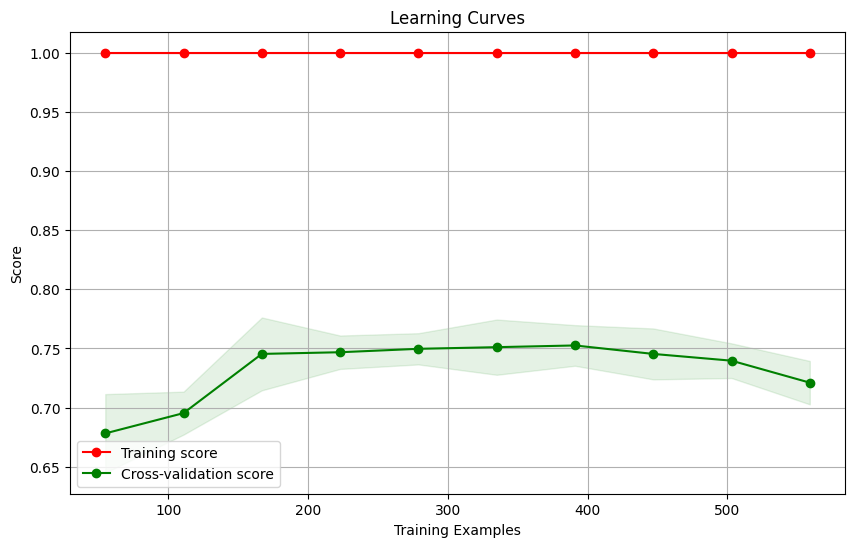

In [15]:
# Plot learning curve 
plot_learning_curves(log_reg_model, x_train, y_train, x_val, y_val)

#### Hyperparameter Tuning 

In [16]:
log_reg_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

# Create the grid search object
grid_search = GridSearchCV(estimator=log_reg_model, param_grid=param_grid, cv=None)

# Perform grid search
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best cross-validation score
best_score = grid_search.best_score_
print("Best Cross-Validation Score:", best_score)

# Train the model with the best hyperparameters on the entire training dataset
best_model = grid_search.best_estimator_

val_score = best_model.score(x_val, y_val)
print("Validation Set Accuracy:", val_score)

saveModel('log_reg_best.pkl', best_model)

### Random Forest

In [27]:
# initialize and train the Random Forest model
'''enter your code here'''
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)

# predict labels for the validation set
'''enter your code here'''
rf_clf_predictions = rf_clf.predict(x_val)

# report the validation accuracy of the trained model
'''enter your code here'''
accuracy = accuracy_score(rf_clf_predictions, y_val)
print("Accuracy (Random Forest):", accuracy)

saveModel('rf_clf.pkl', rf_clf)

Accuracy (Random Forest): 0.7931034482758621


In [ ]:
plot_learning_curves(rf_clf, x_train, y_train, x_val, y_val)

#### Hyperparameter Tuning 

In [34]:
rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(rf_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best cross-validation score
best_score = grid_search.best_score_
print("Best Cross-Validation Score:", best_score)

# Train the model with the best hyperparameters on the entire training dataset
best_model = grid_search.best_estimator_
val_pred = best_model.predict(x_val)

# Evaluate accuracy on the validation set
val_score = best_model.score(val_pred, y_val)
print("Validation Set Accuracy:", val_score)

results.append((best_model, val_score))

saveModel('rf_clf_best.pkl', best_model)

### SVM

In [28]:
# initialize and train the Support Vector Machines model
'''enter your code here'''
svm_clf = SVC()
svm_clf.fit(x_train, y_train)

# report the number of support vectors
'''enter your code here'''
num_support_vectors = svm_clf.n_support_
print("Number of support vectors for each class:", num_support_vectors)

# predict labels for the validation set
'''enter your code here'''
val_pred = svm_clf.predict(x_val)

# report the validation accuracy of the trained model
'''enter your code here'''
accuracy = accuracy_score(val_pred, y_val)
print("Accuracy:", accuracy)

saveModel('svm_clf.pkl', svm_clf)

Number of support vectors for each class: [272  50  10  95]
Accuracy: 0.7931034482758621


In [ ]:
plot_learning_curves(svm_clf, x_train, y_train, x_val, y_val)

#### Hyperparameter Tuning 

In [35]:
svm_clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(x_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

# Get the best cross-validation score
best_score = grid_search.best_score_
print("Best Cross-Validation Score:", best_score)

# Predict on the validation set with the best model
best_model = grid_search.best_estimator_
val_pred = best_model.predict(x_val)

# Evaluate accuracy on the validation set
val_score = best_model.score(val_pred, y_val)
print("Validation Set Accuracy:", val_score)

results.append((best_model, val_score))

saveModel('svm_clf_best.pkl', best_model)

### Gradient Boosting 

In [30]:
'''enter your code here'''
gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train, y_train)

# predict labels for the validation set
'''enter your code here'''
val_pred = gb_clf.predict(x_val)

# report the validation accuracy of the trained model
'''enter your code here'''
accuracy = accuracy_score(y_val, val_pred)
print("Accuracy on validation set:", accuracy)

saveModel('gb_clf.pkl', gb_clf)

Accuracy on validation set: 0.7931034482758621


In [ ]:
plot_learning_curves(gb_clf, x_train, y_train, x_val, y_val)

#### Hyperparameter Tuning 

In [ ]:
gb_clf.get_params()

In [ ]:
param_grid = {
    'criterion': ['friedman_mse', 'squared_error'],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 8]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=None)

# Perform grid search
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best cross-validation score
best_score = grid_search.best_score_
print("Best Cross-Validation Score:", best_score)

# Train the model with the best hyperparameters on the entire training dataset
best_model = grid_search.best_estimator_

val_score = best_model.score(x_val, y_val)
print("Validation Set Accuracy:", val_score)

results.append((best_model, val_score))

saveModel('gb_clf_best.pkl', best_model)

### Neural Network

In [ ]:
def create_dense_model(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),  # Flatten the input images
        Dense(128, activation='relu'),  # First hidden layer with 128 units and ReLU activation
        Dense(64, activation='relu'),   # Second hidden layer with 64 units and ReLU activation
        Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation for binary classification
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# function to extract the dense model from the pipeline
def extract_model(pipeline):
    return pipeline.steps[-1][1]

# Create a pipeline for the dense model
dense_pipeline = Pipeline([
    ('flatten', FunctionTransformer(lambda x: x.reshape((x.shape[0], -1)))),
    ('dense', KerasClassifier(build_fn=create_dense_model, input_shape=(10000,), epochs=10, batch_size=32))
])

# train the network
'''enter your code here'''
nn_model = extract_model(dense_pipeline)
nn_model.fit(x_train, y_train)

# predict labels for the validation set
'''enter your code here'''
val_pred = nn_model.predict(x_val)

# report the validation accuracy of the trained model
'''enter your code here'''
accuracy = accuracy_score(y_val, val_pred)
print("Validation accuracy:", accuracy)

saveModel('nn_model.pkl', nn_model)

In [ ]:
plot_learning_curves(nn_model, x_train, y_train, x_val, y_val)

#### Hyperparameter Tuning

In [ ]:
nn_model.get_params()

In [ ]:
param_dist = {
    # 'hidden_layers': [1, 3, 5],  # Number of hidden layers
    # 'units': [50, 100, 150, 200],       # Number of units in hidden layers
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    # 'learning_rate': [0.01, 0.1, 0.2],
    'batch_size': [32, 64, 128]
}

# print(nn_model.get_params().keys())

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(nn_model, param_dist, n_iter=50, cv=5)

# Fit RandomizedSearchCV
random_search.fit(x_train, y_train)

# Print the best parameters found
print("Best Parameters:", random_search.best_params_)

# Get the best model
best_model = random_search.best_estimator_
val_pred = best_model.predict(x_val)

# Evaluate accuracy on the validation set
val_score = best_model.score(val_pred, y_val)
print("Validation Set Accuracy:", val_score)

results.append((best_model, val_score))

saveModel('nn_model_best.pkl', best_model)

## Part 3: Feature Selection (Check if it should be done before or after model training)


## Part 4: Choosing the best model 

In [ ]:
print(results)
general_best = max(results, key=lambda x: x[1])
general_best_model = general_best[0]
print(general_best_model)

test_pred = general_best_model.predict(x_test)

accuracy = accuracy_score(y_test, test_pred)
print("Test Accuracy:", accuracy)

## Part 5: Testing the best model on the test data